In [ ]:
import os
from tqdm import tqdm
import random
import pandas as pd
in_train_root = '/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/ILSVRC/Data/CLS-LOC/train/'
# dset = torchvision.datasets.ImageNet(in_root, split='val')

# Adapted from https://www.kaggle.com/code/tusonggao/create-imagenet-train-subset-100k

def get_all_files(directory):
    filenames = []
    class_name = directory.split('/')[-1]
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            filenames.append(filename)
            part_name = filename.split('_')[0]
            assert part_name == class_name
    return filenames, class_name

train_path = in_train_root
# new_train_path = '/kaggle/working/imagenet_subtrain/'

filenames = []

dirs = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
print('len(dirs): ', len(dirs))

number_per_class = 100
filenames_li = []
class_name_li = []
for i, directory in enumerate(tqdm(dirs)):
    directory_path = train_path + directory
    filenames, class_name = get_all_files(directory_path)
    filenames = random.sample(filenames, number_per_class)
    classnames = [class_name for i in range(number_per_class)]
    assert len(filenames)==number_per_class
    # write the filenames and targets into one column.
    filenames_li.extend(filenames)
    class_name_li.extend(classnames)
    # make sure the target is the right imagenet index (how to go from synsets to indices).
df = pd.DataFrame({'filename': filenames_li, 'target': class_name_li})
df.to_csv('train_targets.csv', index=False)

In [8]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr
import pandas as pd
from PIL import Image
import numpy as np
import transformers
from transformers import VideoMAEConfig, VideoMAEModel

In [10]:
class ValDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = f"{self.root_dir}{self.data.iloc[idx, 0]}.JPEG"
        image = Image.open(img_name)
        label = self.data.iloc[idx, 1].split()[0]

        if self.transform:
            image = self.transform(image)

        return image, label   

class TrainDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = f"{self.root_dir}/{self.data.iloc[idx, 1]}/{self.data.iloc[idx, 0]}"
        image = Image.open(img_name)
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [27]:
# val_transform = transforms.Compose(
#             [
#                 transforms.Resize(256),
#                 transforms.CenterCrop(224),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean, std),
#             ]
#         )

def transform_image_cifar10_or_imagenet(image):
#     Used for standard single image datasets such as torchvision.CIFAR10, torchvision.ImageNet
#     if image.shape[0]!=3:
    image_size=224
    num_frames=16
    mean = [0.5, 0.5, 0.5]#np.mean(mean_all, axis=0) #mean_all[chosen_subj] 
    std = [0.25, 0.25, 0.25] #std_all[chosen_subj] 
    
#     [0.485, 0.456, 0.406]  # IMAGENET_DEFAULT_MEAN
#     [0.229, 0.224, 0.225]  # IMAGENET_DEFAULT_STD

    augs = [tr.ToTensor(),
            tr.Resize(image_size), tr.CenterCrop(image_size),
            tr.ConvertImageDtype(torch.float32), 
             tr.Normalize(mean,std)]
    transform = tr.Compose(augs)

    return transform(image)#.unsqueeze(0).repeat(num_frames,1,1,1)

In [28]:
val_dataset = ValDataset(csv_file='/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/LOC_val_solution.csv', root_dir='/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/ILSVRC/Data/CLS-LOC/val/', transform=transform_image_imagenet)
train_dataset = TrainDataset(csv_file='/N/project/baby_vision_curriculum/github/baby-vision-curriculum/benchmarks/imagenet/train_targets.csv', root_dir='/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/ILSVRC/Data/CLS-LOC/train/', transform=transform_image_imagenet)

Collate function None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 224, 224])


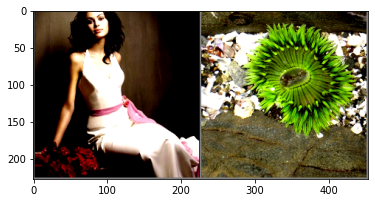

n03450230 n01914609


In [29]:
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data.distributed import DistributedSampler
# functions to show an image
batch_size=2

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
world_size = 4
seed = 211
rank = 0
pin_memory = True
sampler_shuffle = True
collate_fn = None
num_workers = 6
datasets = {'train': train_dataset, 'val':val_dataset}
samplers_dict = {x: DistributedSampler(datasets[x], num_replicas=world_size, 
                                           rank=rank, shuffle=sampler_shuffle, 
                                           seed=seed)
                     for x in ['train', 'val']}
print("Collate function", collate_fn)
dataloaders = {x: torch.utils.data.DataLoader(
        datasets[x], batch_size=batch_size, pin_memory=pin_memory, collate_fn=collate_fn,
        num_workers=num_workers, shuffle=False, sampler=samplers_dict[x], drop_last=True)
                        for x in ['train', 'val']}
dataiter = iter(dataloaders['train'])
images,labels = next(dataiter)
# print(type(batch))
# show images
print(images.shape)
imshow(torchvision.utils.make_grid(images))
# # print labels
print(' '.join(f'{labels[j]:5s}' for j in range(batch_size)))

In [30]:
def make_imagenet_dataset():
    imagenet_train_root='/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/ILSVRC/Data/CLS-LOC/'
    val_path = '/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/LOC_val_solution.csv'
    train_path = '/N/project/baby_vision_curriculum/github/baby-vision-curriculum/benchmarks/imagenet/train_targets.csv'
    train_dataset = TrainDataset(csv_file=train_path, root_dir=f"{imagenet_train_root}/train/",
                                                            transform=transform_image_cifar10_or_imagenet)
    val_dataset =  ValDataset(csv_file=val_path, root_dir=f"{imagenet_train_root}/val/", transform=transform_image_cifar10_or_imagenet)
    image_datasets = {'train': train_dataset , 'val':val_dataset}
    num_classes = 1000 
        
    return image_datasets, num_classes

In [31]:
def get_config(image_size, args, num_labels=2):
    arch_kw = args.architecture
    if arch_kw=='base': #default
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=16, tubelet_size=2, 
                                             hidden_size=768, num_hidden_layers=12, num_attention_heads=12,
                                             intermediate_size=3072, initializer_range=0.02,
                                             use_mean_pooling=True, decoder_num_attention_heads=6,
                                             decoder_hidden_size=384, decoder_num_hidden_layers=4, 
                                             decoder_intermediate_size=1536, norm_pix_loss=True)

In [32]:
def init_model_from_checkpoint(model, checkpoint_path):
    # caution: model class
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def adapt_videomae(source_model, target_model):
    # load the embeddings
    target_model.videomae.embeddings.load_state_dict(
        source_model.videomae.embeddings.state_dict())
#     load the encoder
    target_model.videomae.encoder.load_state_dict(
        source_model.videomae.encoder.state_dict())
    return target_model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
            
def get_model(image_size, num_labels, feature_extracting):
    config_source = get_config(image_size)
    model_source = transformers.VideoMAEForPreTraining(config_source)
    
    if args.init_checkpoint_path!='na':
        print('args.init_checkpoint_path:',args.init_checkpoint_path)
        # initialize the model using the checkpoint
        model_source = init_model_from_checkpoint(model_source, args.init_checkpoint_path)
  
    config_target = get_config(image_size, args, num_labels=num_labels)
    model_target = transformers.VideoMAEForVideoClassification(config=config_target)
    model_target = adapt_videomae(model_source, model_target)
    if not torch.all(
        model_target.videomae.embeddings.patch_embeddings.projection.weight==model_source.videomae.embeddings.patch_embeddings.projection.weight):
        warnings.warn('Model not successfully initialized')
    
    if feature_extracting:
        set_parameter_requires_grad(model_target, feature_extracting)
    
    return model_target

        
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def get_optimizer(model, feature_extract, args):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

#     if feature_extract:
    lr = args.lr#1e-3
    weight_decay =args.wd#5e-5
    optimizer_ft = torch.optim.Adam(params_to_update, lr=lr, weight_decay=weight_decay)
    #     optimizer_ft = torch.optim.SGD([{'params': params_to_update, 
    #                               'initial_lr':lr}], 
    #                             lr=lr, momentum=0.9)
#     else:
#         lr=1e-4
#         optimizer_ft = torch.optim.Adam(params_to_update, lr=lr)
        
    return optimizer_ft


In [35]:
datasets, num_classes = make_imagenet_dataset()
feature_extract = True
#     model_type = 'res50'
#-----------------
# Create the criterion
#     criterion = torch.nn.CrossEntropyLoss()


# Instantiate the model, optimizer
#Load the model, adapt it to the downstream task
image_size = 224
feature_extract = True
xmodel = get_model(image_size, num_classes, feature_extract, args)

xmodel = xmodel.to(rank)

NameError: name 'args' is not defined

In [15]:
num_epochs = 2
for i_ep in range(num_epochs):
#         if verbose:
    print('Epoch {}/{}'.format(i_ep, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        print("Here")
        dataloaders[phase].sampler.set_epoch(i_ep)
        print("I'm here")
        if phase == 'train':
            xmodel.train()  # Set model to training mode
        else:
            xmodel.eval()   # Set model to evaluate mode

        running_loss = torch.tensor([0.0], device=rank)
        running_corrects = torch.tensor([0.0], device=rank)

        i_iter, print_period=0, 100
#             i_break, print_period = 20,1 #@@@ debug
        # Iterate over data.
        print("phase", phase)
        print("dataloader phase", dataloaders[phase])
        dataiter = iter(dataloaders[phase])
        images, labels = next(dataiter)
        print(images.shape)
        for batch in tqdm(dataloaders[phase]):
            # zero the parameter gradients
            optimizer.zero_grad()

#                 loss, logits = get_loss(task, batch, phase, rank, args)

            # implement get_loss for different datasets and for videomaeclassifier
            inputs, labels = batch #get_inp_label(args.task, batch)
            print("Here", inputs.shape)
            inputs = inputs.to(rank)
            labels = labels.to(rank)
            outputs = xmodel(pixel_values=inputs, labels=labels)

            logits = outputs.logits
            loss = outputs.loss

            _, preds = torch.max(logits, 1)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
#                 print(rank, 'labels shape, device: ', labels.shape, labels.data.device)
#                 print(rank, 'preds shape, device: ', preds.shape, preds.device)
            running_corrects += torch.sum(preds == labels.data)

            i_iter+=1

Epoch 0/1
----------
Here
I'm here


NameError: name 'xmodel' is not defined

In [25]:
import pandas as pd

df = pd.read_csv('/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/LOC_val_solution.csv')

In [27]:
df.head(5)
# df['PredictionString'][0].split()[0]

,ImageId,PredictionString
0,ILSVRC2012_val_00048981,n03995372 85 1 499 272
1,ILSVRC2012_val_00037956,n03481172 131 0 499 254
2,ILSVRC2012_val_00026161,n02108000 38 0 464 280
3,ILSVRC2012_val_00026171,n03109150 0 14 216 299
4,ILSVRC2012_val_00008726,n02119789 255 142 454 329 n02119789 44 21 322 ...


In [15]:
img = Image.open('/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/ILSVRC/Data/CLS-LOC/train/n02112137/n02112137_5210.JPEG')
img = np.array(img)
img.shape

(333, 500, 3)

In [23]:
def transform_image_cifar10_or_imagenet(image):
#     Used for standard single image datasets such as torchvision.CIFAR10, torchvision.ImageNet
#     if image.shape[0]!=3:
    image_size=224
    num_frames=16
    mean = [0.5, 0.5, 0.5]#np.mean(mean_all, axis=0) #mean_all[chosen_subj] 
    std = [0.25, 0.25, 0.25] #std_all[chosen_subj] 
    
#     [0.485, 0.456, 0.406]  # IMAGENET_DEFAULT_MEAN
#     [0.229, 0.224, 0.225]  # IMAGENET_DEFAULT_STD

    augs = [tr.ToTensor(),
            tr.Resize(image_size), tr.CenterCrop(image_size),
            tr.ConvertImageDtype(torch.float32), 
             tr.Normalize(mean,std)]
    transform = tr.Compose(augs)

    return transform(image).unsqueeze(0).repeat(num_frames,1,1,1)
# Apply the transformation
tensor_image = transform_image_cifar10_or_imagenet(img)
tensor_image.shape

torch.Size([16, 3, 224, 224])